# 🏃 Text-to-Motion Retrieval — Challenge Notebook

**Approach** : Contrastive learning dans un espace partagé texte–mouvement.  
- **Text encoder** : `sentence-transformers` (MiniLM) pré-entraîné + projection MLP  
- **Motion encoder** : Transformer encoder + projection MLP  
- **Loss** : InfoNCE symétrique (NT-Xent)  
- **Anti-overfitting** : dropout, weight decay, early stopping, augmentation motion, multiple text views

## 0. Installation des dépendances

In [ ]:
!pip install sentence-transformers -q

## 1. Imports & Configuration

In [9]:
import os
import random
import glob
import numpy as np
import pandas as pd
from pathlib import Path
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from tqdm import tqdm

# ─── Chemins ──────────────────────────────────────────────────────────────────
BASE_DIR    = Path("./data/data")          # adapter si besoin
MOTION_DIR  = BASE_DIR / "motions"
TEXT_DIR    = BASE_DIR / "texts"
TEST_DIR    = BASE_DIR / "test"
TRAIN_FILE  = BASE_DIR / "train.txt"

# ─── Hyperparamètres ──────────────────────────────────────────────────────────
CFG = dict(
    seed           = 42,
    val_ratio      = 0.15,          # fraction du train pour la validation
    max_frames     = 200,           # troncature / padding des séquences
    n_joints       = 44,
    joint_dim      = 9,
    motion_dim     = 44 * 9,        # 396 features par frame
    d_model        = 256,
    nhead          = 8,
    num_layers     = 4,
    dim_ff         = 512,
    dropout        = 0.2,
    embed_dim      = 256,           # dimension espace partagé
    temperature    = 0.07,
    batch_size     = 64,
    lr             = 3e-4,
    weight_decay   = 1e-2,
    epochs         = 80,
    patience       = 12,            # early stopping
    text_model     = "all-MiniLM-L6-v2",
    device         = "cuda" if torch.cuda.is_available() else "cpu",
)

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(CFG["seed"])
print(f"Device : {CFG['device']}")

Device : cuda


## 2. Chargement des données

In [10]:
# ─── Lecture du split train ────────────────────────────────────────────────────
with open(TRAIN_FILE) as f:
    train_ids = [line.strip() for line in f if line.strip()]

print(f"Nombre de motions en train : {len(train_ids)}")

# ─── Chargement textes ────────────────────────────────────────────────────────
def load_texts(motion_id: str) -> list[str]:
    """Retourne les N descriptions associées à un motion_id."""
    txt_path = TEXT_DIR / f"{motion_id}.txt"
    with open(txt_path, "r", encoding="utf-8") as f:
        lines = [l.strip() for l in f.readlines() if l.strip()]
    return lines

# ─── Chargement motions ───────────────────────────────────────────────────────
def load_motion(path) -> np.ndarray:
    """Charge un fichier .npy et retourne (T, N*d)."""
    x = np.load(path).astype(np.float32)   # (T, N, d) ou (T, N*d)
    if x.ndim == 3:
        x = x.reshape(x.shape[0], -1)      # → (T, 396)
    return x

# ─── Vérification rapide ──────────────────────────────────────────────────────
sample_id = train_ids[0]
sample_motion = load_motion(MOTION_DIR / f"{sample_id}.npy")
sample_texts  = load_texts(sample_id)
print(f"Motion shape : {sample_motion.shape}")
print(f"Textes ({len(sample_texts)}) : {sample_texts}")


# ← AJOUT : détection automatique de la dimension réelle
ACTUAL_MOTION_DIM = sample_motion.shape[1]
print(f"motion_dim détecté automatiquement : {ACTUAL_MOTION_DIM}")
CFG["motion_dim"] = ACTUAL_MOTION_DIM   # écrase la valeur par défaut

Nombre de motions en train : 6018
Motion shape : (80, 384)
Textes (3) : ['two people burst into laughter with hands on their hips and looking upwards.', 'the two persons are standing with hands on their waists, tilting their heads back and laughing loudly.', 'both persons stand with hands on hips, tilt their heads back and burst out into laughter.']
motion_dim détecté automatiquement : 384


## 3. Pré-calcul des embeddings texte (Sentence-BERT figé)

In [11]:
# On gèle le modèle texte et on pré-calcule les embeddings → gain de temps + régularisation
sbert = SentenceTransformer(CFG["text_model"])
sbert.eval()

TEXT_EMB_DIM = sbert.get_sentence_embedding_dimension()
print(f"Dimension SBERT : {TEXT_EMB_DIM}")

# Collecte de tous les textes du train
all_sentences = []
sentence_index = {}   # motion_id → indices dans all_sentences

for mid in train_ids:
    descs = load_texts(mid)
    start = len(all_sentences)
    all_sentences.extend(descs)
    sentence_index[mid] = list(range(start, start + len(descs)))

print(f"Total phrases : {len(all_sentences)}")

with torch.no_grad():
    all_text_embs = sbert.encode(
        all_sentences, batch_size=256, show_progress_bar=True,
        normalize_embeddings=True, convert_to_numpy=True
    )  # (N_phrases, TEXT_EMB_DIM)

all_text_embs = all_text_embs.astype(np.float32)
print(f"Embeddings texte shape : {all_text_embs.shape}")

Loading weights: 100%|██████████| 103/103 [00:00<00:00, 946.27it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Dimension SBERT : 384
Total phrases : 18054


Batches: 100%|██████████| 71/71 [00:03<00:00, 20.23it/s]


Embeddings texte shape : (18054, 384)


## 4. Dataset & DataLoader

In [12]:
def pad_or_truncate(motion: np.ndarray, max_frames: int) -> tuple[np.ndarray, np.ndarray]:
    """Retourne (motion_padded, mask) où mask=1 sur les frames réelles."""
    T = motion.shape[0]
    D = motion.shape[1]
    if T >= max_frames:
        return motion[:max_frames], np.ones(max_frames, dtype=np.float32)
    pad = np.zeros((max_frames - T, D), dtype=np.float32)
    mask = np.array([1.0] * T + [0.0] * (max_frames - T), dtype=np.float32)
    return np.vstack([motion, pad]), mask


def augment_motion(motion: np.ndarray) -> np.ndarray:
    """Augmentations légères : bruit gaussien + dropout de frames."""
    # Bruit additif
    motion = motion + np.random.normal(0, 0.005, motion.shape).astype(np.float32)
    # Dropout de frames (10 % max)
    T = motion.shape[0]
    if T > 10:
        n_drop = int(T * 0.1)
        drop_idx = np.random.choice(T, n_drop, replace=False)
        motion[drop_idx] = 0.0
    return motion


class MotionTextDataset(Dataset):
    def __init__(self, motion_ids, all_text_embs, sentence_index,
                 motion_dir, max_frames, augment=False):
        self.motion_ids    = motion_ids
        self.all_text_embs = all_text_embs
        self.sentence_index = sentence_index
        self.motion_dir    = Path(motion_dir)
        self.max_frames    = max_frames
        self.augment       = augment

    def __len__(self):
        return len(self.motion_ids)

    def __getitem__(self, idx):
        mid = self.motion_ids[idx]

        # ── Motion ──────────────────────────────────────────────────────────────
        motion = load_motion(self.motion_dir / f"{mid}.npy")
        if self.augment:
            motion = augment_motion(motion)
        motion, mask = pad_or_truncate(motion, self.max_frames)

        # ── Texte : on tire une description au hasard parmi les 3 ─────────────
        indices = self.sentence_index[mid]
        chosen  = random.choice(indices)
        text_emb = self.all_text_embs[chosen]

        return (
            torch.from_numpy(motion),           # (T, D)
            torch.from_numpy(mask),             # (T,)
            torch.from_numpy(text_emb),         # (TEXT_EMB_DIM,)
        )


# ─── Split train / val ───────────────────────────────────────────────────────
random.shuffle(train_ids)
n_val   = max(1, int(len(train_ids) * CFG["val_ratio"]))
val_ids = train_ids[:n_val]
tr_ids  = train_ids[n_val:]
print(f"Train : {len(tr_ids)} | Val : {len(val_ids)}")

train_ds = MotionTextDataset(tr_ids,  all_text_embs, sentence_index,
                             MOTION_DIR, CFG["max_frames"], augment=True)
val_ds   = MotionTextDataset(val_ids, all_text_embs, sentence_index,
                             MOTION_DIR, CFG["max_frames"], augment=False)

train_loader = DataLoader(train_ds, batch_size=CFG["batch_size"],
                          shuffle=True,  num_workers=2, pin_memory=True, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=CFG["batch_size"],
                          shuffle=False, num_workers=2, pin_memory=True)

print(f"Batches train : {len(train_loader)} | Batches val : {len(val_loader)}")

Train : 5116 | Val : 902
Batches train : 79 | Batches val : 15


## 5. Architecture des modèles

In [13]:
# ─── Motion Encoder ──────────────────────────────────────────────────────────
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe.unsqueeze(0))  # (1, max_len, d_model)

    def forward(self, x):
        return self.dropout(x + self.pe[:, :x.size(1)])


class MotionEncoder(nn.Module):
    def __init__(self, motion_dim, d_model, nhead, num_layers, dim_ff,
                 dropout, embed_dim):
        super().__init__()
        self.input_proj = nn.Sequential(
            nn.Linear(motion_dim, d_model),
            nn.LayerNorm(d_model),
        )
        self.pos_enc = PositionalEncoding(d_model, dropout=dropout)
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_ff,
            dropout=dropout, batch_first=True, norm_first=True
        )
        self.transformer = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        # Projection vers l'espace partagé
        self.proj = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, embed_dim),
        )

    def forward(self, x, mask):
        """
        x    : (B, T, motion_dim)
        mask : (B, T)  — 1=frame réelle, 0=padding
        """
        x = self.input_proj(x)                      # (B, T, d_model)
        x = self.pos_enc(x)
        # key_padding_mask : True = position à ignorer
        pad_mask = (mask == 0)                       # (B, T)
        x = self.transformer(x, src_key_padding_mask=pad_mask)  # (B, T, d_model)
        # Moyenne pondérée sur les frames réelles
        m = mask.unsqueeze(-1)                       # (B, T, 1)
        x = (x * m).sum(1) / m.sum(1).clamp(min=1)  # (B, d_model)
        return F.normalize(self.proj(x), dim=-1)     # (B, embed_dim)


# ─── Text Projection ─────────────────────────────────────────────────────────
class TextProjection(nn.Module):
    """MLP qui projette les embeddings SBERT figés vers l'espace partagé."""
    def __init__(self, text_emb_dim, embed_dim, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(text_emb_dim, embed_dim * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim * 2, embed_dim),
        )

    def forward(self, t):
        return F.normalize(self.net(t), dim=-1)


motion_enc = MotionEncoder(
    motion_dim = CFG["motion_dim"],
    d_model    = CFG["d_model"],
    nhead      = CFG["nhead"],
    num_layers = CFG["num_layers"],
    dim_ff     = CFG["dim_ff"],
    dropout    = CFG["dropout"],
    embed_dim  = CFG["embed_dim"],
).to(CFG["device"])

text_proj = TextProjection(
    text_emb_dim = TEXT_EMB_DIM,
    embed_dim    = CFG["embed_dim"],
    dropout      = CFG["dropout"],
).to(CFG["device"])

n_params_m = sum(p.numel() for p in motion_enc.parameters() if p.requires_grad)
n_params_t = sum(p.numel() for p in text_proj.parameters()  if p.requires_grad)
print(f"Motion Encoder params : {n_params_m:,}")
print(f"Text Projection params : {n_params_t:,}")

Motion Encoder params : 2,339,072
Text Projection params : 328,448


/tmp/ipykernel_84980/2424159067.py:30: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  self.transformer = nn.TransformerEncoder(enc_layer, num_layers=num_layers)


## 6. Loss InfoNCE symétrique

In [14]:
def info_nce_loss(z_motion: torch.Tensor, z_text: torch.Tensor, temp: float) -> torch.Tensor:
    """
    z_motion, z_text : (B, embed_dim) — déjà normalisés L2.
    Retourne la loss InfoNCE symétrique.
    """
    B = z_motion.size(0)
    logits = (z_motion @ z_text.T) / temp         # (B, B)
    labels = torch.arange(B, device=logits.device)
    loss_m2t = F.cross_entropy(logits,   labels)  # motion → text
    loss_t2m = F.cross_entropy(logits.T, labels)  # text → motion
    return (loss_m2t + loss_t2m) / 2.0

## 7. Boucle d'entraînement

In [15]:
# ─── Optimiseur & Scheduler ──────────────────────────────────────────────────
params = list(motion_enc.parameters()) + list(text_proj.parameters())
optimizer = AdamW(params, lr=CFG["lr"], weight_decay=CFG["weight_decay"])
scheduler = CosineAnnealingLR(optimizer, T_max=CFG["epochs"], eta_min=1e-6)


def run_epoch(loader, train=True):
    motion_enc.train(train)
    text_proj.train(train)
    total_loss = 0.0
    ctx = torch.enable_grad() if train else torch.no_grad()
    with ctx:
        for motion, mask, text_emb in loader:
            motion   = motion.to(CFG["device"])
            mask     = mask.to(CFG["device"])
            text_emb = text_emb.to(CFG["device"])

            z_m = motion_enc(motion, mask)
            z_t = text_proj(text_emb)
            loss = info_nce_loss(z_m, z_t, CFG["temperature"])

            if train:
                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(params, 1.0)
                optimizer.step()

            total_loss += loss.item()
    return total_loss / len(loader)


# ─── Boucle principale ───────────────────────────────────────────────────────
train_losses, val_losses = [], []
best_val_loss = float("inf")
patience_counter = 0
CKPT_PATH = "best_model.pt"

for epoch in range(1, CFG["epochs"] + 1):
    tr_loss  = run_epoch(train_loader, train=True)
    val_loss = run_epoch(val_loader,   train=False)
    scheduler.step()

    train_losses.append(tr_loss)
    val_losses.append(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save({
            "motion_enc": motion_enc.state_dict(),
            "text_proj":  text_proj.state_dict(),
        }, CKPT_PATH)
    else:
        patience_counter += 1

    if epoch % 5 == 0 or patience_counter == 0:
        print(f"Epoch {epoch:3d} | Train {tr_loss:.4f} | Val {val_loss:.4f} "
              f"| Best {best_val_loss:.4f} | Patience {patience_counter}/{CFG['patience']}")

    if patience_counter >= CFG["patience"]:
        print(f"Early stopping à l'epoch {epoch}.")
        break

print("Entraînement terminé !")

Epoch   1 | Train 3.8080 | Val 3.3806 | Best 3.3806 | Patience 0/12
Epoch   2 | Train 3.2849 | Val 3.0375 | Best 3.0375 | Patience 0/12
Epoch   3 | Train 2.9726 | Val 2.9201 | Best 2.9201 | Patience 0/12
Epoch   4 | Train 2.7704 | Val 2.7121 | Best 2.7121 | Patience 0/12
Epoch   5 | Train 2.6274 | Val 2.6321 | Best 2.6321 | Patience 0/12
Epoch   6 | Train 2.4890 | Val 2.5497 | Best 2.5497 | Patience 0/12
Epoch   7 | Train 2.3757 | Val 2.5469 | Best 2.5469 | Patience 0/12
Epoch   8 | Train 2.2832 | Val 2.4905 | Best 2.4905 | Patience 0/12
Epoch   9 | Train 2.1919 | Val 2.4590 | Best 2.4590 | Patience 0/12
Epoch  10 | Train 2.0846 | Val 2.4269 | Best 2.4269 | Patience 0/12
Epoch  12 | Train 1.9219 | Val 2.4039 | Best 2.4039 | Patience 0/12
Epoch  14 | Train 1.7660 | Val 2.3836 | Best 2.3836 | Patience 0/12
Epoch  15 | Train 1.6867 | Val 2.4102 | Best 2.3836 | Patience 1/12
Epoch  16 | Train 1.6107 | Val 2.3628 | Best 2.3628 | Patience 0/12
Epoch  20 | Train 1.3467 | Val 2.4095 | Best 2.3

## 8. Courbes Train / Val Loss

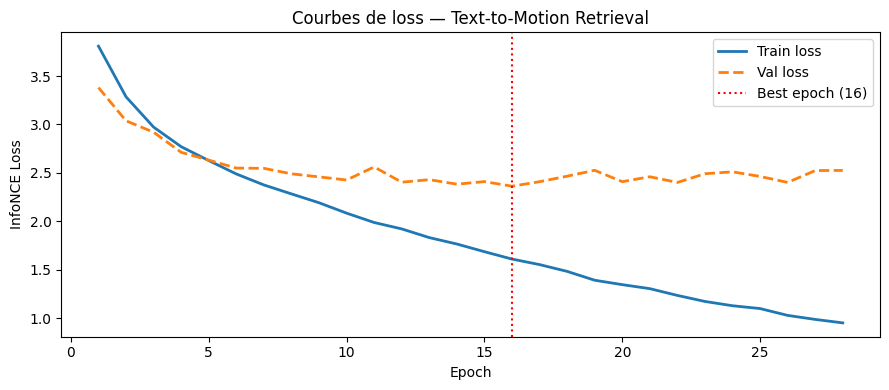

Meilleure val loss : 2.3628 à l'epoch 16


In [16]:
plt.figure(figsize=(9, 4))
epochs_done = range(1, len(train_losses) + 1)
plt.plot(epochs_done, train_losses, label="Train loss", linewidth=2)
plt.plot(epochs_done, val_losses,   label="Val loss",   linewidth=2, linestyle="--")
best_ep = int(np.argmin(val_losses)) + 1
plt.axvline(best_ep, color="red", linestyle=":", label=f"Best epoch ({best_ep})")
plt.xlabel("Epoch")
plt.ylabel("InfoNCE Loss")
plt.title("Courbes de loss — Text-to-Motion Retrieval")
plt.legend()
plt.tight_layout()
plt.savefig("loss_curves.png", dpi=150)
plt.show()
print(f"Meilleure val loss : {best_val_loss:.4f} à l'epoch {best_ep}")

## 9. Score Kaggle sur la validation (Recall@K pondéré)

In [17]:
# ─── Chargement du meilleur checkpoint ───────────────────────────────────────
ckpt = torch.load(CKPT_PATH, map_location=CFG["device"])
motion_enc.load_state_dict(ckpt["motion_enc"])
text_proj.load_state_dict(ckpt["text_proj"])
motion_enc.eval()
text_proj.eval()


def compute_kaggle_score(motion_ids_pool, K=10):
    """
    Évalue le score Kaggle (Recall@K pondéré) sur un pool de motions.
    Pour chaque motion du pool on tire UNE description comme query,
    et on vérifie si le bon motion est retrouvé.
    """
    weights = {k: 1.0 / k for k in range(1, K + 1)}
    recalls = {k: 0.0 for k in range(1, K + 1)}
    N = len(motion_ids_pool)

    # ── Encode toutes les motions du pool ────────────────────────────────────
    all_motion_embs = []
    with torch.no_grad():
        for mid in motion_ids_pool:
            mot = load_motion(MOTION_DIR / f"{mid}.npy")
            mot, msk = pad_or_truncate(mot, CFG["max_frames"])
            mot_t = torch.from_numpy(mot).unsqueeze(0).to(CFG["device"])
            msk_t = torch.from_numpy(msk).unsqueeze(0).to(CFG["device"])
            z_m = motion_enc(mot_t, msk_t)          # (1, embed_dim)
            all_motion_embs.append(z_m.squeeze(0).cpu())
    Z_motions = torch.stack(all_motion_embs)         # (N, embed_dim)

    # ── Pour chaque motion, une query texte ──────────────────────────────────
    with torch.no_grad():
        for gt_idx, mid in enumerate(motion_ids_pool):
            idxs   = sentence_index[mid]
            chosen = random.choice(idxs)
            t_emb  = torch.from_numpy(all_text_embs[chosen]).unsqueeze(0).to(CFG["device"])
            z_t    = text_proj(t_emb).squeeze(0).cpu()  # (embed_dim,)

            sims   = (Z_motions @ z_t).numpy()           # (N,)
            ranked = np.argsort(-sims)                   # du + similaire au -

            for k in range(1, K + 1):
                if gt_idx in ranked[:k]:
                    recalls[k] += 1.0

    for k in recalls:
        recalls[k] /= N

    # Score pondéré
    score = sum(weights[k] * recalls[k] for k in range(1, K + 1)) / sum(weights.values())
    return recalls, score


print("Calcul du score Kaggle sur le split de validation...")
val_recalls, val_score = compute_kaggle_score(val_ids, K=10)

print(f"\n{'k':>4} | {'Recall@k':>10}")
print("-" * 18)
for k, v in sorted(val_recalls.items()):
    print(f"{k:>4} | {v:.4f}")
print(f"\n→ Score Kaggle pondéré (val) : {val_score:.4f}")

Calcul du score Kaggle sur le split de validation...

   k |   Recall@k
------------------
   1 | 0.0599
   2 | 0.1153
   3 | 0.1641
   4 | 0.1918
   5 | 0.2262
   6 | 0.2528
   7 | 0.2805
   8 | 0.2960
   9 | 0.3149
  10 | 0.3337

→ Score Kaggle pondéré (val) : 0.1546


In [ ]:
# ─── Visualisation Recall@K ──────────────────────────────────────────────────
ks = sorted(val_recalls.keys())
plt.figure(figsize=(7, 4))
plt.bar(ks, [val_recalls[k] for k in ks], color="steelblue")
plt.xticks(ks)
plt.xlabel("K")
plt.ylabel("Recall@K")
plt.title(f"Recall@K (validation) — Score pondéré = {val_score:.4f}")
plt.tight_layout()
plt.savefig("recall_at_k.png", dpi=150)
plt.show()

## 10. Génération du fichier de soumission CSV

In [ ]:
# ─── Chargement meilleur checkpoint (au cas où la cellule est ré-exécutée) ────
ckpt = torch.load(CKPT_PATH, map_location=CFG["device"])
motion_enc.load_state_dict(ckpt["motion_enc"])
text_proj.load_state_dict(ckpt["text_proj"])
motion_enc.eval()
text_proj.eval()

TOP_K      = 10
N_BATCHES  = 30
rows       = []

with torch.no_grad():
    for batch_id in range(1, N_BATCHES + 1):
        batch_dir = TEST_DIR / str(batch_id)

        # ── Query ─────────────────────────────────────────────────────────────
        query_path = batch_dir / "query.txt"
        with open(query_path, "r", encoding="utf-8") as f:
            query_text = f.read().strip()

        query_emb = sbert.encode(
            [query_text], normalize_embeddings=True, convert_to_numpy=True
        ).astype(np.float32)                                    # (1, TEXT_EMB_DIM)

        z_q = text_proj(
            torch.from_numpy(query_emb).to(CFG["device"])
        ).squeeze(0).cpu()                                      # (embed_dim,)

        # ── Candidates ────────────────────────────────────────────────────────
        motion_files = sorted(batch_dir.glob("motion_*.npy"))
        assert len(motion_files) == 32, f"Batch {batch_id} : {len(motion_files)} motions trouvées"

        # Identifiant numérique extrait du nom de fichier (ex: motion_07.npy → 7)
        motion_ids_batch = [
            int(p.stem.replace("motion_", "")) for p in motion_files
        ]

        # Encode chaque motion candidate
        motion_embs = []
        for mp in motion_files:
            mot = load_motion(mp)
            mot, msk = pad_or_truncate(mot, CFG["max_frames"])
            mot_t = torch.from_numpy(mot).unsqueeze(0).to(CFG["device"])
            msk_t = torch.from_numpy(msk).unsqueeze(0).to(CFG["device"])
            z_m = motion_enc(mot_t, msk_t).squeeze(0).cpu()    # (embed_dim,)
            motion_embs.append(z_m)

        Z_cands = torch.stack(motion_embs)                      # (32, embed_dim)
        sims    = (Z_cands @ z_q).numpy()                       # (32,)

        # ── Ranking ───────────────────────────────────────────────────────────
        ranked_local  = np.argsort(-sims)[:TOP_K]               # indices locaux dans le batch
        ranked_ids    = [motion_ids_batch[i] for i in ranked_local]

        # Vérification unicité
        assert len(set(ranked_ids)) == TOP_K, "IDs dupliqués dans le ranking !"

        row = {"query_id": batch_id}
        for rank, mid in enumerate(ranked_ids, 1):
            row[f"candidate_{rank}"] = mid
        rows.append(row)

        print(f"Batch {batch_id:2d} | Query : {query_text[:60]}...")
        print(f"          Top-3 IDs : {ranked_ids[:3]}")

# ─── Sauvegarde CSV ──────────────────────────────────────────────────────────
submission = pd.DataFrame(rows)
submission.to_csv("submission.csv", index=False)
print(f"\n✅ submission.csv généré ({len(submission)} lignes)")
submission.head()

## 11. (Optionnel) Re-ranking par moyenne des 3 descriptions

Pour chaque batch on peut encoder les **3 descriptions** du query si on les a, et moyenner les scores — cela donne généralement un léger boost.

In [ ]:
# ─── Re-ranking multi-description (si le fichier query contient plusieurs lignes) ─
rows_rerank = []

with torch.no_grad():
    for batch_id in range(1, N_BATCHES + 1):
        batch_dir = TEST_DIR / str(batch_id)

        with open(batch_dir / "query.txt", "r", encoding="utf-8") as f:
            lines = [l.strip() for l in f if l.strip()]

        # Si le fichier query ne contient qu'une ligne, on ne peut pas multi-view
        queries = lines if len(lines) > 1 else lines

        query_embs = sbert.encode(
            queries, normalize_embeddings=True, convert_to_numpy=True
        ).astype(np.float32)                                    # (n_q, TEXT_EMB_DIM)

        Z_queries = text_proj(
            torch.from_numpy(query_embs).to(CFG["device"])
        ).cpu()                                                 # (n_q, embed_dim)

        motion_files = sorted(batch_dir.glob("motion_*.npy"))
        motion_ids_batch = [int(p.stem.replace("motion_", "")) for p in motion_files]

        motion_embs = []
        for mp in motion_files:
            mot = load_motion(mp)
            mot, msk = pad_or_truncate(mot, CFG["max_frames"])
            mot_t = torch.from_numpy(mot).unsqueeze(0).to(CFG["device"])
            msk_t = torch.from_numpy(msk).unsqueeze(0).to(CFG["device"])
            z_m = motion_enc(mot_t, msk_t).squeeze(0).cpu()
            motion_embs.append(z_m)

        Z_cands = torch.stack(motion_embs)                     # (32, embed_dim)
        # Moyenne des similarités sur toutes les descriptions de la query
        sims = (Z_cands @ Z_queries.T).mean(dim=1).numpy()    # (32,)

        ranked_local = np.argsort(-sims)[:TOP_K]
        ranked_ids   = [motion_ids_batch[i] for i in ranked_local]

        row = {"query_id": batch_id}
        for rank, mid in enumerate(ranked_ids, 1):
            row[f"candidate_{rank}"] = mid
        rows_rerank.append(row)

submission_rerank = pd.DataFrame(rows_rerank)
submission_rerank.to_csv("submission_multiview.csv", index=False)
print("✅ submission_multiview.csv généré")
submission_rerank.head()

---
## Résumé de l'approche

| Composant | Choix | Raison anti-overfitting |
|---|---|---|
| Texte | SBERT figé + MLP projecteur | Pré-entraînement riche, peu de paramètres appris |
| Motion | Transformer Encoder | Capture les dépendances temporelles longues |
| Loss | InfoNCE symétrique | Apprentissage par contraste, robuste au bruit |
| Régularisation | Dropout 0.2, Weight Decay 1e-2, Grad Clip | Évite la sur-spécialisation |
| Data augmentation | Bruit gaussien + frame dropout | Réduit le surapprentissage sur les motions |
| Multiple descriptions | Tirage aléatoire à chaque batch | Régularisation implicite supplémentaire |
| Early stopping | Patience 12 epochs | Arrête avant le surajustement |